In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
## folders
input_files_folder = '../../../fred_input_files'

## Parameters
alpha = 0.05

In [8]:
data_folder             = '../data'
geo_colombia_info_file  = 'geoinfo_municipios_colombia.csv'

In [9]:
df_mun_info = pd.read_csv(f'{data_folder}/{geo_colombia_info_file}')[['COD_DEPTO','NOM_DEPART']].drop_duplicates()

In [10]:
## Load known info
# Load and preprocess data
df_contacts_11 = pd.read_csv(f'{input_files_folder}/contacts/community_survey_11001.csv')
df_contacts_11_ = df_contacts_11.copy()
df_contacts_11['Date'] = pd.to_datetime(df_contacts_11['Date'])
df_contacts_11 = df_contacts_11[['Date', 'Contacts_total']]

df_mobility_11 = pd.read_csv(f'{input_files_folder}/mobility_trends/11_mobility_trends.csv')
df_mobility_11['date'] = pd.to_datetime(df_mobility_11['date'])
df_mobility_11['mobility_trend'] = 1 + df_mobility_11['mobility_trend'].ewm(alpha=alpha).mean()

df_combined_11 = pd.merge(df_contacts_11, df_mobility_11, left_on='Date', right_on='date', how='inner')

# Drop rows with NaN values created by lagging
df_combined_11.dropna(inplace=True)

In [11]:
depart_list = df_mun_info.COD_DEPTO.unique()

In [12]:
for dept in [11]:
    if dept == 999:
        continue

    # Load mobility data for another population (e.g., population 8)
    df_mobility_8 = pd.read_csv(f'{input_files_folder}/mobility_trends/{dept}_mobility_trends.csv')
    df_mobility_8['date'] = pd.to_datetime(df_mobility_8['date'])
    df_mobility_8['mobility_trend'] = 1 + df_mobility_8['mobility_trend'].ewm(alpha=alpha).mean()

    df_combined_88 = pd.merge(df_contacts_11, df_mobility_8, left_on='Date', right_on='date', how='inner')

    # Drop rows with NaN values created by lagging
    df_combined_88.dropna(inplace=True)

    a1 = (df_combined_11['mobility_trend'].ewm(alpha=alpha).mean())
    a2 = (df_combined_88['mobility_trend'].ewm(alpha=alpha).mean())

    frac = a2 / a1
    contact_estimation = frac * df_combined_11['Contacts_total'].to_numpy()

    df_ = pd.DataFrame({'Date':df_contacts_11_.Date,
                        'day':df_contacts_11_.day,
                        'Contacts_total':contact_estimation})

    df_['Contacts_Prop'] = df_.Contacts_total / df_.iloc[0].Contacts_total

    #df_.to_csv(f'{input_files_folder}/contacts/{dept}_contacts.csv', index=False)
    #df_.to_csv(f'../output_files/{dept}_contacts.csv', index=False)

In [13]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime

In [14]:
# Convert 'Date' columns to datetime format
df_['Date'] = pd.to_datetime(df_['Date'])
df_mobility_11['date'] = pd.to_datetime(df_mobility_11['date'])

# Merge on Date
df_combined = pd.merge(df_, df_mobility_11, left_on='Date', right_on='date', how='inner')

In [53]:
# Assuming you are predicting 'Contacts_total' using 'mobility_trend' as exogenous data
y = df_combined['Contacts_total']
X = df_combined['mobility_trend']

# Split into train and test sets
train_size = int(len(df_combined) * 0.95)
y_train, y_test = y[0:train_size], y[train_size:]
X_train, X_test = X[0:train_size].values.reshape(-1,1), X[train_size:].values.reshape(-1,1)

In [54]:
import numpy as np
import pandas as pd
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Assuming your DataFrame and target/exogenous variables are defined as before

# Using auto_arima to find the best ARIMA model parameters based on AIC
# We enable seasonal detection this time
auto_arima_model = pm.auto_arima(y_train, exogenous=X_train,
                                 seasonal=True,  # Enable seasonal detection
                                 m=6,  # This is the seasonal period; adjust according to your data (e.g., 12 for monthly data)
                                 trace=True, error_action='ignore', suppress_warnings=True,
                                 stepwise=True)

# Print the summary of the best model found
print(auto_arima_model.summary())

# The best model's non-seasonal parameters
p, d, q = auto_arima_model.order

# The best model's seasonal parameters
P, D, Q, m = auto_arima_model.seasonal_order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=-2373.264, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=-933.005, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=-923.971, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[6] intercept   : AIC=-2359.055, Time=0.65 sec
 ARIMA(2,1,2)(1,0,0)[6] intercept   : AIC=-2376.900, Time=1.04 sec
 ARIMA(2,1,2)(0,0,0)[6] intercept   : AIC=-2361.051, Time=0.61 sec
 ARIMA(2,1,2)(2,0,0)[6] intercept   : AIC=-2278.956, Time=1.47 sec
 ARIMA(2,1,2)(2,0,1)[6] intercept   : AIC=-2276.154, Time=0.82 sec
 ARIMA(1,1,2)(1,0,0)[6] intercept   : AIC=-1620.406, Time=0.54 sec
 ARIMA(2,1,1)(1,0,0)[6] intercept   : AIC=-2341.897, Time=0.64 sec
 ARIMA(3,1,2)(1,0,0)[6] intercept   : AIC=-2413.181, Time=0.45 sec
 ARIMA(3,1,2)(0,0,0)[6] intercept   : AIC=-2487.565, Time=0.21 sec
 ARIMA(3,1,2)(0,0,1)[6] intercept   : AIC=-2485.613, Time=0.80 sec
 ARIMA(3,

In [55]:
# Define the ARIMAX model with the parameters found from auto_arima
arimax_model = SARIMAX(y_train,
                       exog=X_train,
                       order=(p, d, q),  # Parameters from auto_arima
                       seasonal_order=(P, D, Q, m),  # Adjust if your data is seasonal
                       enforce_stationarity=False,
                       enforce_invertibility=False)

# Fit the ARIMAX model
arimax_results = arimax_model.fit()

# Summary of the model
print(arimax_results.summary())

# Predictions
predictions = arimax_results.forecast(steps=len(y_test), exog=X_test)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.81384D+00    |proj g|=  4.29624D+00

At iterate    5    f= -3.81460D+00    |proj g|=  9.20738D+00

At iterate   10    f= -3.91276D+00    |proj g|=  2.36463D+02

At iterate   15    f= -4.51451D+00    |proj g|=  3.58681D+00

At iterate   20    f= -4.71440D+00    |proj g|=  8.34013D+00

At iterate   25    f= -5.03843D+00    |proj g|=  6.54379D+02


 This problem is unconstrained.



At iterate   30    f= -6.12662D+00    |proj g|=  7.09363D+01

At iterate   35    f= -7.08508D+00    |proj g|=  7.22712D+01

At iterate   40    f= -7.27025D+00    |proj g|=  3.13461D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45    119      2     0     0   1.164D+02  -7.273D+00
  F =  -7.2732528091450259     

ABNORMAL_TERMINATION_IN_LNSRCH                              
                               SARIMAX Results                                
Dep. Variable:         Contacts_total   No. Observations:                  148
Model:               SARIMAX(3, 1, 2)   Log Likelihood                1076.441



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/zine/HPC02S1/ex-dveloza/mambaforge/envs/sktime/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f"MAE: {mae}")
print(f"MSE: {mse}")


MAE: 0.006995722981497643
MSE: 8.075694829273627e-05


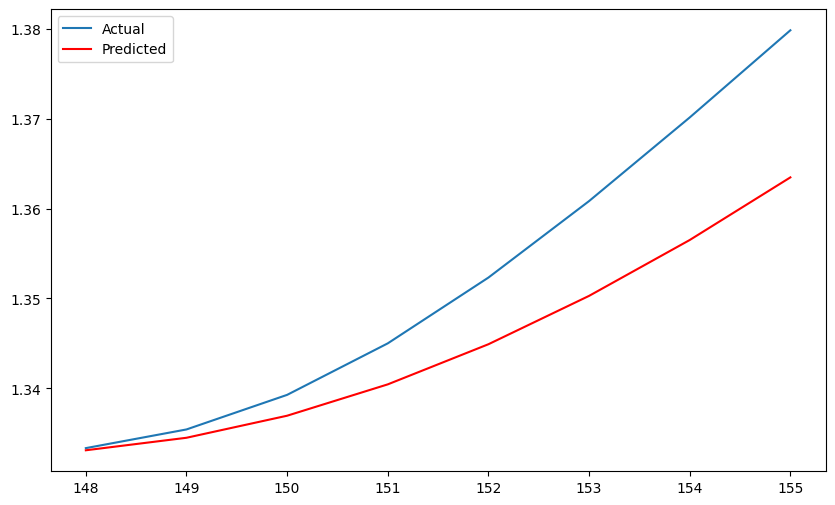

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, predictions, color='red', label='Predicted')
plt.legend()
plt.show()
